This notebook is taking data and computing its persistence diagram, determining the energy computation and applying PCA and TDR
https://scikit-tda.org/DREiMac/api.html

In [1]:
import time
import numpy as np
from scipy.spatial import distance

#topological data analysis
from ripser import ripser
from persim import plot_diagrams

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
%matplotlib inline

import math
import cmath
from definitions import pentagon

import random
# import numpy as np

#manifold learning and dim red
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding as LLE

#topological data analysis
from dreimac import CircularCoords, CircleMapUtils, ToroidalCoords, GeometryUtils

#plotting and visualization
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
import pandas as pd
import base64

from matplotlib import cm
# import matplotlib.pyplot as plt
# %matplotlib inline


def plot_barcodes(diagrams, alpha_max, width = 1.5):
    max_dim = len(diagrams)
    fig, axs = plt.subplots(max_dim)
    fig.suptitle('Barcodes')
    for dim in range(max_dim):
        barcode = np.copy(diagrams[dim])
        ind_inf = np.isinf(barcode.T[1])
        barcode[ind_inf, 1] = alpha_max
        h = 1
        for i in range(len(barcode)):
            x = barcode[i]
            y = [h,h]
            axs[dim].plot(x, y, linestyle= '-', c='#1f77b4', linewidth = width)
            if ind_inf[i]:
                axs[dim].scatter([alpha_max],[h],  s=10, marker='>', c='#1f77b4')
            h += 1
        axs[dim].set_xlim(0, 1.05*alpha_max)
        axs[dim].set_ylim(0,h)
        axs[dim].get_yaxis().set_ticks([]);
        axs[dim].spines['right'].set_color('none')
        axs[dim].spines['top'].set_color('none')
        axs[dim].text(0.3,1,'$\mathrm{bcd}^{\mathcal{R}}_{'+str(dim)+'}(X)$', verticalalignment='bottom')

In [2]:
# upload the excel files using pandas

penta2 = np.loadtxt('1. data/G1.txt', delimiter=',')

print(penta2.shape)

# print(2%%2)

(39583, 10)


[ 1.          0.          0.75497164  0.04960951  0.19072165  0.37228884
 -0.40514988  0.44255347  0.          0.        ]
[1.0, 0.7549716416382538, 0.19072164948453607, -0.40514988126251794, 0.0]
[0.0, 0.049609511170214796, 0.3722888355071321, 0.4425534698914557, 0.0]


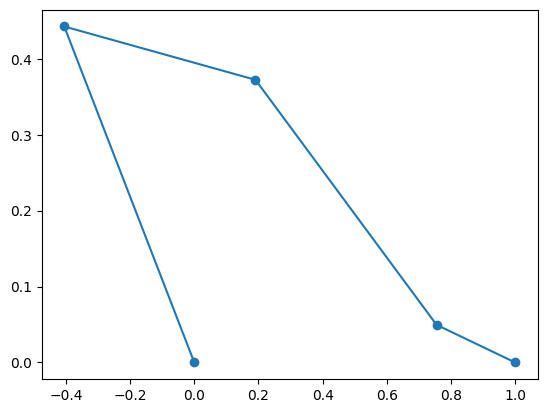

In [3]:
sample1 = penta2[2000]
x_val = []
y_val = []

for i in range(10):
    if i%2 == 0:
        x_val.append(sample1[i])
    else: 
        y_val.append(sample1[i])

print(sample1)
print(x_val)
print(y_val)

plt.plot(x_val, y_val)
plt.scatter(x_val, y_val)

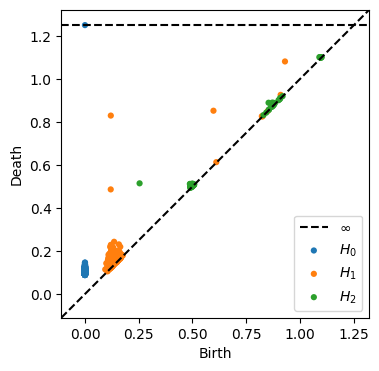

In [4]:
#Using Ripser, we will find the persistence diagrams
#Here I am referecing code from Demo 6 in Day 5 DREimac

n_land = 900
res = ripser(penta2, n_perm = n_land, maxdim=2, coeff =13, thresh = 1.8)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)

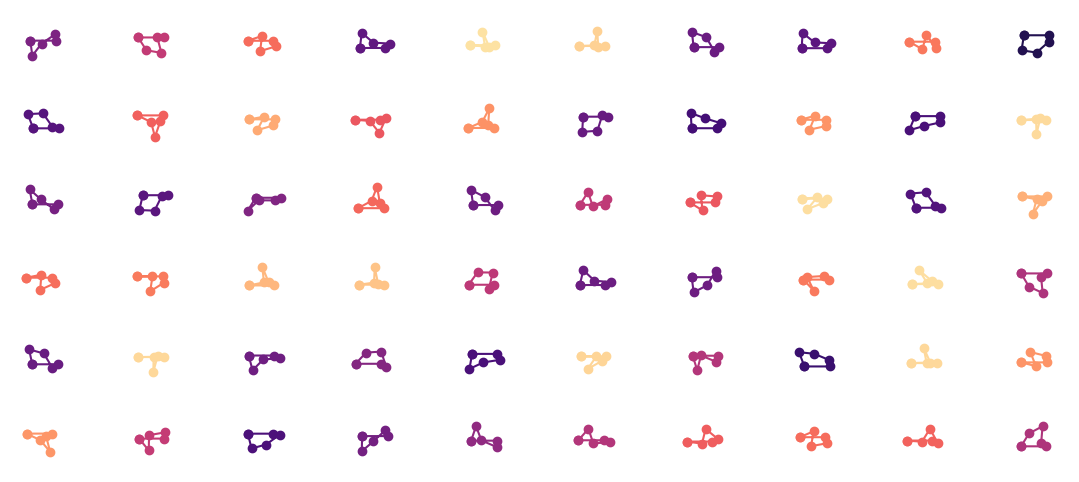

In [8]:
#Energy Computation

angle_data = np.zeros((penta2.shape[0],5)) # internal angles

for i in range(5):
    ii = (2*i -2)%10
    jj = (2*i - 1)%10
    u = penta2[:, [ii, jj]]
    
    ii = (2*i)%10
    jj = (2*i + 1)%10
    v = penta2[:, [ii , jj]]
    
    ii = (2*i + 2)%10
    jj = (2*i + 3)%10
    w = penta2[:, [ii, jj]]
    
    z = np.sum((u - v)*(w-v), axis = 1)
    
    angle_data[:,i]  = np.arccos( np.minimum(z,1) )
    
energy = np.sum((angle_data - (3/5)*np.pi)**2 , axis = 1)

# plot sample pentagons
plt.figure(figsize=(14,6))
for i in range(60):
    ind = random.randint(0, penta2.shape[0])
    x = penta2[ind].reshape(5,2).T
    cent = np.mean(x,axis=1)
    plt.subplot(6,10,i+1)
    plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[ind]/np.max(energy)))
    plt.axis('square')
    plt.axis('off')
    plt.xlim(cent[0]-1.3,cent[0]+1.3);
    plt.ylim(cent[1]-1.3,cent[1]+1.3);

In [ ]:
n_land = 900
k_neigh = 20
dist_mat, pointcloud_permutation = GeometryUtils.landmark_geodesic_distance(penta2, n_land, k_neigh)

In [6]:
pers1 = dgms[1][:,1] - dgms[1][:,0]
pers2 = dgms[2][:,1] - dgms[2][:,0]

pers1_sorted = np.sort(pers1)[::-1]
pers2_sorted = np.sort(pers2[pers2 < np.Inf])[::-1]

print('Persistence of top 10 1-d features:\n', np.around(pers1_sorted[0:10],decimals=2), '\n')
print('Persistence of top 10 2-d features:\n', np.around(pers2_sorted[0:10],decimals=2))

n_lands = 900

#cc = CircularCoords(dist_mat , n_landmarks= n_lands, distance_matrix=True)
cc = CircularCoords(penta2 , n_landmarks= n_lands)

coho_classes = [0, 1, 2, 3]

circular_coords = []

for i in coho_classes:
    circular_coords.append(cc.get_coordinates(perc = 0.6, cocycle_idx=i, standard_range= False))

# print("space space")
# print(circular_coords)
# print("Shape of Circular Coords")
# print(np.array(circular_coords).shape)

Persistence of top 10 1-d features:
 [0.71 0.37 0.25 0.15 0.11 0.11 0.1  0.1  0.1  0.09] 

Persistence of top 10 2-d features:
 [0.26 0.04 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]


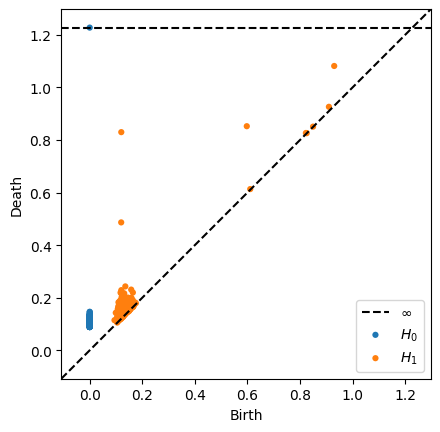

In [13]:
n_landmarks = 900

tc = ToroidalCoords(penta2, n_landmarks=n_landmarks)
plot_diagrams(tc.dgms_)

In [17]:
cohomology_classes = [0, 1, 2]
toroidal_coords = tc.get_coordinates(cocycle_idxs=cohomology_classes)
toroidal_coords = CircleMapUtils.linear_combination(np.array(circular_coords), [[1,0,0,0], [0,1,0,0],[0,0,1,0], [0,0,0,1]])
t1=CircleMapUtils.center(toroidal_coords[0])
t2=CircleMapUtils.center(toroidal_coords[1])
t3=CircleMapUtils.center(toroidal_coords[2])
t4=CircleMapUtils.center(toroidal_coords[3])

fig = go.Figure(data=[go.Scatter3d(
    x=t1, y=t2, z=t3, 
    mode ='markers', 
    marker=dict(size = 3, color =energy, colorscale='plasma')
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show(renderer='chrome')

NameError: name 't3' is not defined

In [18]:
#Applying Circular coords and doing TDR

thetas= CircleMapUtils.linear_combination(np.array(circular_coords), [[1,0,0,0], [0,1,0,0],[0,0,1,0], [0,0,0,1]])
# [[1,0,0,0,0], [0,1,0,0,0],[0,0,1,0,0], [-1,0,0,1,0], [0,0,0,0,1]]) #this combo worked for 2 and 4, 2 and 5

theta1 = CircleMapUtils.center(thetas[0])
theta2 = CircleMapUtils.center(thetas[1])
theta3 = CircleMapUtils.center(thetas[2])
theta4 = CircleMapUtils.center(thetas[3])



# Plot the data using the computed circular coordintaes, and colors given by pentagon energy
fig = go.Figure(data=[go.Scatter3d(
    x=theta1, y=theta2, z=theta4, 
    mode ='markers', 
    marker=dict(size = 3, color =energy, colorscale='plasma')
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show(renderer='chrome')

#Creating a 2D plot of thetas

# plt.scatter(theta1, theta2)
# plt.scatter(theta1, theta3) #good under 0,1,3,4 and standard basis
# plt.scatter(theta2, theta3)
# plt.scatter(theta1, theta4)
# plt.scatter(theta2, theta4) #perfect in standard basis under 0,1,3,4
# plt.scatter(theta3, theta4)


In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(2, 2)
  
# # For 1 and 2 Function
# axis[0, 0].scatter(theta1, theta2)
# axis[0, 0].set_title("1 and 2")
  
# # For 1 and 3 Function
# axis[0, 1].scatter(theta1, theta3)
# axis[0, 1].set_title("1 and 3")
  
# # For 1 and 4 Function
# axis[1, 0].scatter(theta1, theta4)
# axis[1, 0].set_title("1 and 4")
  
# # For 1 and 5 Function
# axis[1, 1].scatter(theta1, theta4)
# axis[1, 1].set_title("1 and 4")
  
# # Combine all the operations and display
# figure.tight_layout()
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(2, 2)
  
# # For 2 and 1 Function
# axis[0, 0].scatter(theta2, theta1)
# axis[0, 0].set_title("2 and 1")
  
# # For 2 and 3 Function
# axis[0, 1].scatter(theta2, theta3)
# axis[0, 1].set_title("2 and 3")
  
# # For 2 and 4 Function
# axis[1, 0].scatter(theta2, theta4)
# axis[1, 0].set_title("2 and 4")
  
# # For 2 and 5 Function
# axis[1, 1].scatter(theta2, theta4)
# axis[1, 1].set_title("2 and 4")
  
# # Combine all the operations and display
# figure.tight_layout()
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(2, 2)
  
# # For 3 and 1 Function
# axis[0, 0].scatter(theta3, theta1)
# axis[0, 0].set_title("3 and 1")
  
# # For 3 and 2 Function
# axis[0, 1].scatter(theta3, theta2)
# axis[0, 1].set_title("3 and 2")
  
# # For 3 and 4 Function
# axis[1, 0].scatter(theta3, theta4)
# axis[1, 0].set_title("3 and 4")
  
# # For 3 and 5 Function
# axis[1, 1].scatter(theta3, theta4)
# axis[1, 1].set_title("3 and 4")
  
# # Combine all the operations and display
# figure.tight_layout()
# plt.show()

In [ ]:
# # Initialise the subplot function using number of rows and columns
# figure, axis = plt.subplots(2, 2)
  
# # For 4 and 1 Function
# axis[0, 0].scatter(theta4, theta1)
# axis[0, 0].set_title("4 and 1")
  
# # For 4 and 2 Function
# axis[0, 1].scatter(theta4, theta2)
# axis[0, 1].set_title("4 and 2")
  
# # For 4 and 3 Function
# axis[1, 0].scatter(theta4, theta3)
# axis[1, 0].set_title("4 and 3")
  
# # For 4 and 5 Function
# axis[1, 1].scatter(theta4, theta4)
# axis[1, 1].set_title("4 and 4")
  
# # Combine all the operations and display
# figure.tight_layout()
# plt.show()

Here we will load the data and save them as pngs, only run these cell blocks once! If you need to run it more, be sure to restart the images file you create

# saving sample pentagons

for i in range(penta2.shape[0]):
#     x_val = []
#     y_val = []

#     for j in range(10):
#         if j%2 == 0:
#             x_val.append(penta2[i][j])
#         else: 
#             y_val.append(penta2[i][j])

#     disp = max(max(x_val), max(y_val))
    pentagon = plt.figure(figsize=(3,3), clear=True)
#     ind = random.randint(0, penta2.shape[0])
    x = penta2[i].reshape(5,2).T
    cent = np.mean(x,axis=1)
    plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[i]/np.max(energy)))
    plt.axis('square')
    plt.axis('off')
#     plt.xlim(disp1-0.1, disp1+0.1)
#     plt.ylim(disp1-0.1, disp1+0.1)
    plt.xlim(cent[0]-1,cent[0]+1);
    plt.ylim(cent[1]-1,cent[1]+1);
    pentagon.savefig('images/'+str(i)+'.png')
    pentagon.clf
    plt.close()

In [ ]:
# # print(penta2[3000])

# x_val = []
# y_val = []

# for i in range(10):
#     if i%2 == 0:
#         x_val.append(penta2[3000][i])
#     else: 
#         y_val.append(penta2[3000][i])



# # plt.plot(x_val, y_val)
# # plt.scatter(x_val, y_val)

# pentagon = plt.figure(figsize=(5,5), clear=True)
# #     ind = random.randint(0, penta2.shape[0])
# x = penta2[3000].reshape(5,2).T
# cent = np.mean(x,axis=1)
# print(cent)
# plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[3000]/np.max(energy)))
# #     plt.axis('square')
# #     plt.axis('off')
# plt.xlim(cent[0]-0.9,cent[0]+0.5);
# plt.ylim(cent[1]-0.5,cent[1]+0.5);
# #     pentagon.savefig('images/'+str(i)+'.png')
# pentagon.clf
# #     plt.close()


Now, we will try and implement the hover data to PCA for the genus 3 surface.
NOTE: When running the hover data box, you can only implement it once per kernel start up. So, if you run it, then made fixes to the code, restart the kernel, run the required code and it will implement correctly.

In [ ]:
#PCA
pca = PCA(n_components=5)
data_pca = pca.fit(penta2).transform(penta2)

print('Explained Variance', pca.explained_variance_ratio_)

fig = go.Figure(data=[go.Scatter3d(
    x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color =energy, colorscale='plasma' , opacity = 1)
)])

fig.update_layout(autosize=False, width=700, height=700)  

fig.show()

In [ ]:
# fig = go.Figure(data=[go.Scatter3d(
#     x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
#     mode ='markers', 
#     marker=dict(size = 3, color =energy, colorscale='plasma' , opacity = 1)
# )])

fig.update_traces(hoverinfo="none", hovertemplate=None)
fig.update_layout(
    scene = dict(
        xaxis = dict(range=[-2,2],),
        yaxis = dict(range=[-2,2],),
        zaxis = dict(range=[-1,1],),
    ), width=700, height=700
)

app = JupyterDash(__name__)

server = app.server

app.layout = html.Div([
    dcc.Graph(id="graph-basic-2", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph-basic-2", "hoverData"),
)

def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]

    img_fname = 'genus 3 - images/'+str(num)+'.png'
    encoded_img = base64.b64encode(open(img_fname, 'rb').read())

    children = [
        html.Div([
            html.Img(src='data:image/png;base64,{}'.format(encoded_img.decode()), style={'width': '100%'}),
        ], style={'width': '80px', 'white-space': 'normal'})
    ]

    return True, bbox, children

app.run_server(mode="inline")
